# Sorce

https://www.kaggle.com/datasets/vencerlanz09/sea-animals-image-dataste?select=Jelly+Fish

# Install Libraries

In [1]:
%pip install tensorflow
%pip install keras
%pip install keras_preprocessing

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Import Libraries

In [25]:
# Import Data Science Libraries
import numpy as np
import pandas as pd

# Import Image Library
from PIL import Image

# Import Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Import System Libraries
from typing import DataFrame,  Any, Dict
from pathlib import Path
import os.path
import shutil
# from google.colab import drive

# Import Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
from collections import Counter
import seaborn as sns
sns.set_style('darkgrid')

# Definine Function

In [3]:
def create_category_image_path_dataframe(folder_path: str) -> DataFrame:
    """Create a DataFrame containing category labels and corresponding image paths."""
    data = []
    for category in os.listdir(folder_path):
        category_path = os.path.join(folder_path, category)
        if os.path.isdir(category_path):
            for filename in os.listdir(category_path):
                if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(category_path, filename)
                    data.append({'Category': category, 'Image_Path': image_path})
    df = pd.DataFrame(data)
    df['Image_Path'] = df['Image_Path'].apply(lambda x: os.path.abspath(x))
    return df

## Augumentation

In [4]:
def balance_dataframe_by_record_reduction(df: DataFrame) -> DataFrame:
    """Balance a DataFrame by reducing the number of records in each category to the minimum."""
    # Calculate the minimum number of records in a category
    min_records = df['Category'].value_counts().min()

    # Function to remove random records from a group
    def remove_random_records(group):
        return group.sample(n=min_records, random_state=42)

    # Remove random records from the DataFrame
    df_balanced = df.groupby('Category', group_keys=False).apply(remove_random_records)

    return df_balanced

def balance_categories_by_copy(df: DataFrame, category_column: str, path_column: str, output_folder: str) -> DataFrame:
    """Balance the categories in a DataFrame by augmenting categories with fewer records."""
    # Find the category with the maximum number of records
    max_category = df[category_column].value_counts().idxmax()
    max_category_count = df[category_column].value_counts().max()

    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through each category
    for category in df[category_column].unique():
        category_count = df[df[category_column] == category].shape[0]

        # Check if the category has fewer records than the maximum category
        if category_count < max_category_count:
            # Calculate the number of images to copy
            num_images_to_copy = max_category_count - category_count

            # Select images from the current category to copy
            images_to_copy = df[df[category_column] == category].sample(n=num_images_to_copy, replace=True)

            # Copy the images to the output folder with a prefix "au_"
            for _, row in images_to_copy.iterrows():
                original_path = row[path_column]
                filename = os.path.basename(original_path)
                new_path = os.path.join(output_folder, f"au_{filename}")
                shutil.copyfile(original_path, new_path)

                # Update the DataFrame with the new path and category
                new_row = {category_column: category, path_column: new_path}
                df = df.append(new_row, ignore_index=True)

    return df

def process_images(folder_path: str, processing_function: callable):
    """Process all images in a folder using the specified processing function. """
    # Check if the path exists and is a folder
    if not os.path.exists(folder_path) or not os.path.isdir(folder_path):
        print("The specified path does not exist or is not a folder.")
        return
    
    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        # Check if the file is an image
        if any(filename.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png', '.bmp']):
            image_path = os.path.join(folder_path, filename)
            try:
                # process the image
                image = processing_function(image_path)
                # Save the processed image with the same name
                image.save(image_path)
                print(f"Processed image: {image_path}")
            except Exception as e:
                print(f"Error processing image {image_path}: {e}")

    Rotacja: Obracanie obrazu o losowy kąt może pomóc w zwiększeniu różnorodności danych.

    Przesunięcie poziome/ pionowe: Przesunięcie obrazu w poziomie lub pionie może pomóc w zwiększeniu tolerancji na translację.

    Zoom: Losowe powiększanie lub pomniejszanie obrazu może pomóc w zwiększeniu elastyczności modelu.

    Zmiana jasności/kontrastu: Losowe zmiany jasności i kontrastu mogą pomóc w zwiększeniu odporności modelu na zmiany oświetlenia.

    Rozmycie: Zastosowanie rozmycia Gaussowskiego lub innego rodzaju rozmycia może pomóc w zmniejszeniu nadmiernego dopasowania.

    Elastyczne przekształcenia: Zastosowanie elastycznych przekształceń, takich jak deformacje lokalne, może pomóc w zwiększeniu odporności na zniekształcenia.

    Dodawanie szumu: Dodanie losowego szumu może pomóc w zwiększeniu ogólnej odporności modelu.

    Odbicie lustrzane: Odbicie obrazu w poziomie lub pionie może zwiększyć różnorodność danych.

    Kombinacja kilku technik: Często skuteczne jest zastosowanie kombinacji różnych technik augmentacji w celu uzyskania najlepszych rezultatów.

In [ ]:

def rotate_image(image_path: str, angle: float) -> np.ndarray:
    """Rotate the input image by the given angle (in degrees)."""
    # Load the image
    image = cv2.imread(image_path)
    
    if image is None:
        raise ValueError(f"Unable to load image from path: {image_path}")

    # Get the image dimensions
    height, width = image.shape[:2]
    
    # Calculate the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)
    
    # Apply the rotation to the image
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image

def resize_image(image_path: str, size: tuple = (50, 50)) -> Image:
    """Resize the input image to 50x50 pixels."""
    image = Image.open(image_path)
    resized_image = image.resize(size)
    return resized_image

def shift_image(image: np.ndarray, shift_x: int = 0, shift_y: int = 0) -> np.ndarray:
    """
    Shift the input image horizontally or vertically."""
    rows, cols = image.shape[:2]
    
    # Define the transformation matrix for shifting
    M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
    
    # Apply the transformation to the image
    shifted_image = cv2.warpAffine(image, M, (cols, rows))
    return shifted_image



## Plot

In [18]:
def plot_category_counts(df: pd.DataFrame) -> None:
    """Plot the count of objects in each category."""
    # Counting the number of objects in each category
    category_counts = df['Category'].value_counts()

    # Creating the bar chart
    plt.figure(figsize=(10, 6))
    category_counts.plot(kind='bar', color='skyblue')
    plt.title('Number of objects in each category')
    plt.xlabel('Category')
    plt.ylabel('Number of objects')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


def plot_images_from_categories(df: pd.DataFrame, category_column: str, path_column: str, num_cols: int = 4) -> None:
    """Plot random images from each category."""
    # Extract unique categories from the DataFrame
    categories = df[category_column].unique()

    # Calculate the number of rows in the grid
    num_rows = (len(categories) + num_cols - 1) // num_cols

    # Create a grid of plots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5*num_rows))

    # Iterate through each category and create plots
    for i, category in enumerate(categories):
        # Select a random image from the given category
        random_image = df[df[category_column] == category].sample(1)
        image_path = random_image[path_column].values[0]

        # Load and display the image at the appropriate position in the grid
        ax = axes[i // num_cols, i % num_cols]
        image = plt.imread(image_path)
        ax.imshow(image)
        ax.set_title(category)
        ax.axis('off')

    # Adjust layout to make the grid centered
    plt.tight_layout()
    plt.show()

def plot_image_dimensions_distribution(df: pd.DataFrame) -> None:
    """Plot the distribution of image dimensions."""
    # Initialize lists to store image dimensions
    dimensions = []

    # Iterate through each image path in the DataFrame
    for image_path in df['Image_Path']:
        # Read the image using OpenCV
        image = cv2.imread(image_path)
        # Get the dimensions of the image
        height, width, _ = image.shape
        # Add a tuple of (width, height) to the dimensions list
        dimensions.append((width, height))

    # Count the occurrences of each dimension pair
    dimension_counts = Counter(dimensions)

    # Separate dimension pairs into lists of widths and heights
    widths, heights = zip(*dimension_counts.keys())

    # Prepare point sizes on the plot (size depends on the count of each pair)
    sizes = [count for count in dimension_counts.values()]

    # Create a scatter plot
    plt.figure(figsize=(12, 8))
    plt.scatter(widths, heights, s=sizes, color='red', alpha=0.5)
    plt.title('Image Dimensions Distribution')
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.grid(True)
    plt.show()

# Connect to source and get data

In [6]:
# drive.mount('/content/drive')

script_dir = Path(__file__).resolve().parent
folder_path = script_dir / 'see_animals_archive'

# Process and analyze the data

# Create dataframe

In [7]:
df_animals = create_category_image_path_dataframe(folder_path)
df_animals.head(10)

Category                                         Image_Path
0    Clams  D:\Coding\Python\See Animal MLN\see_animals_ar...
1    Clams  D:\Coding\Python\See Animal MLN\see_animals_ar...
2    Clams  D:\Coding\Python\See Animal MLN\see_animals_ar...
3    Clams  D:\Coding\Python\See Animal MLN\see_animals_ar...
4    Clams  D:\Coding\Python\See Animal MLN\see_animals_ar...
5    Clams  D:\Coding\Python\See Animal MLN\see_animals_ar...
6    Clams  D:\Coding\Python\See Animal MLN\see_animals_ar...
7    Clams  D:\Coding\Python\See Animal MLN\see_animals_ar...
8    Clams  D:\Coding\Python\See Animal MLN\see_animals_ar...
9    Clams  D:\Coding\Python\See Animal MLN\see_animals_ar...

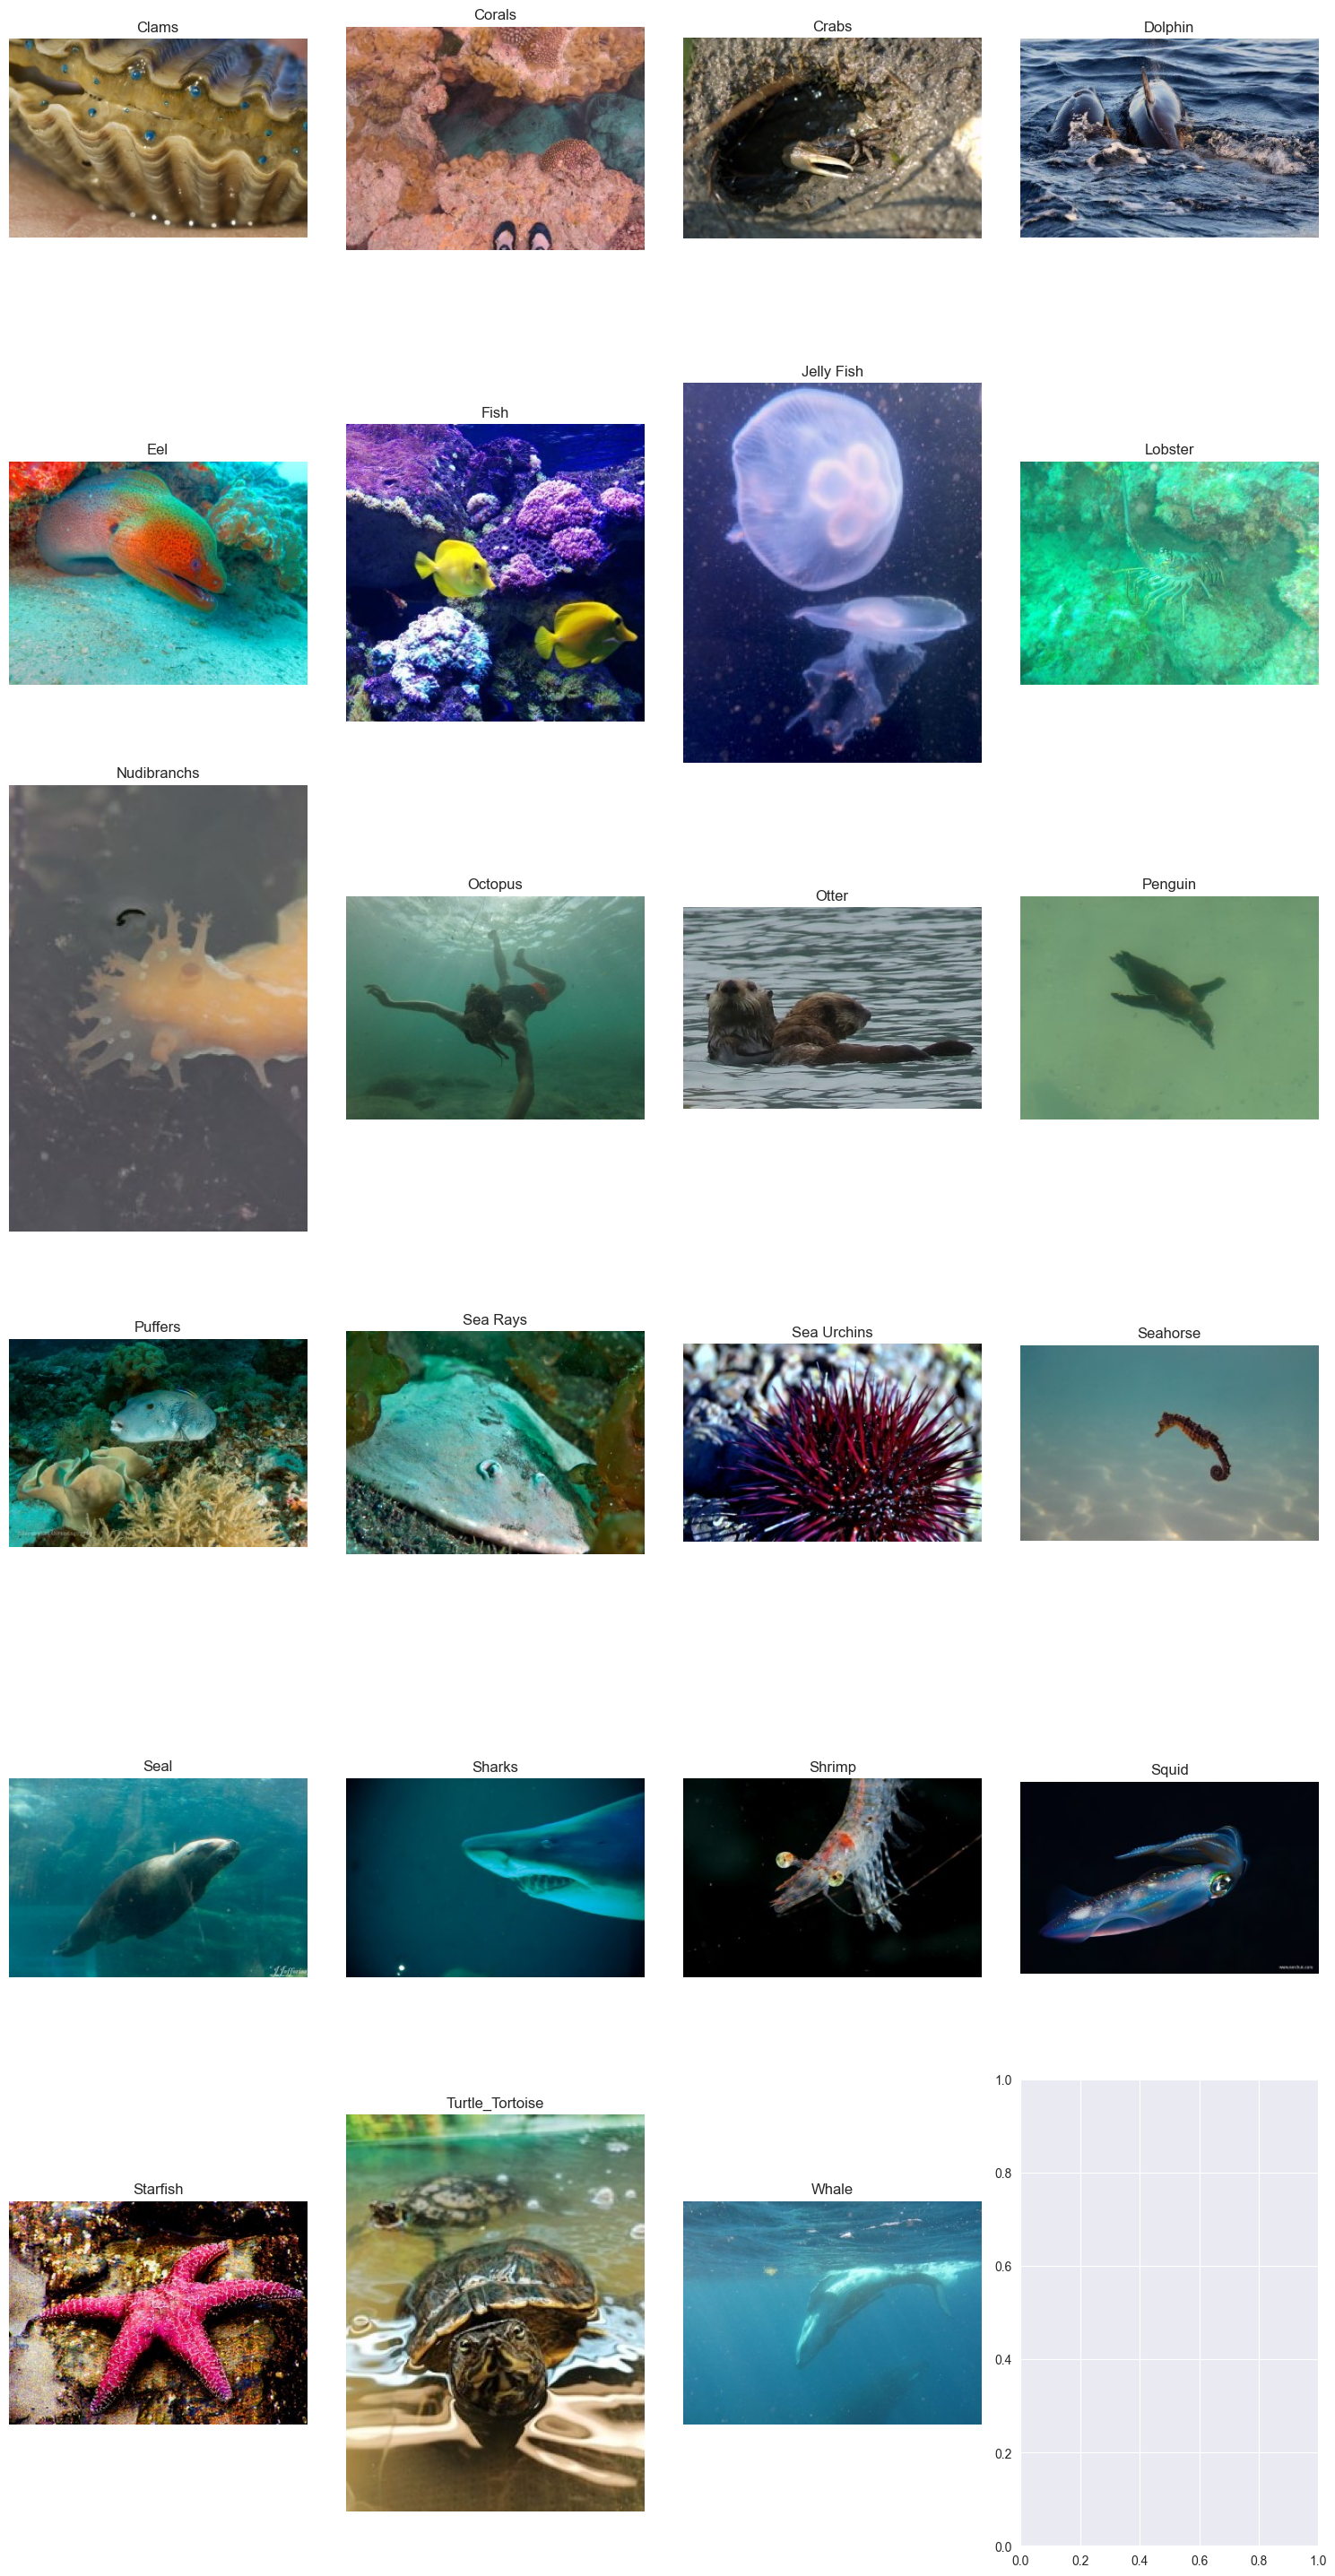

In [8]:
plot_images_from_categories(df_animals, 'Category', 'Image_Path', num_cols = 4)

## Check images dimensions

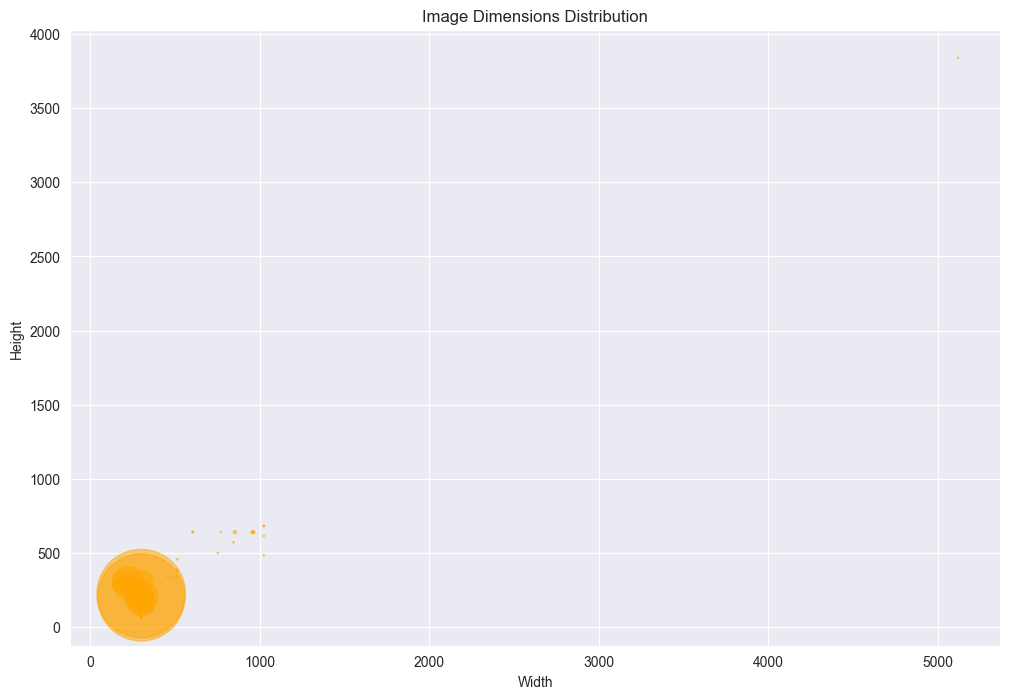

In [29]:
plot_image_dimensions_distribution(df_animals)

## Augmentation

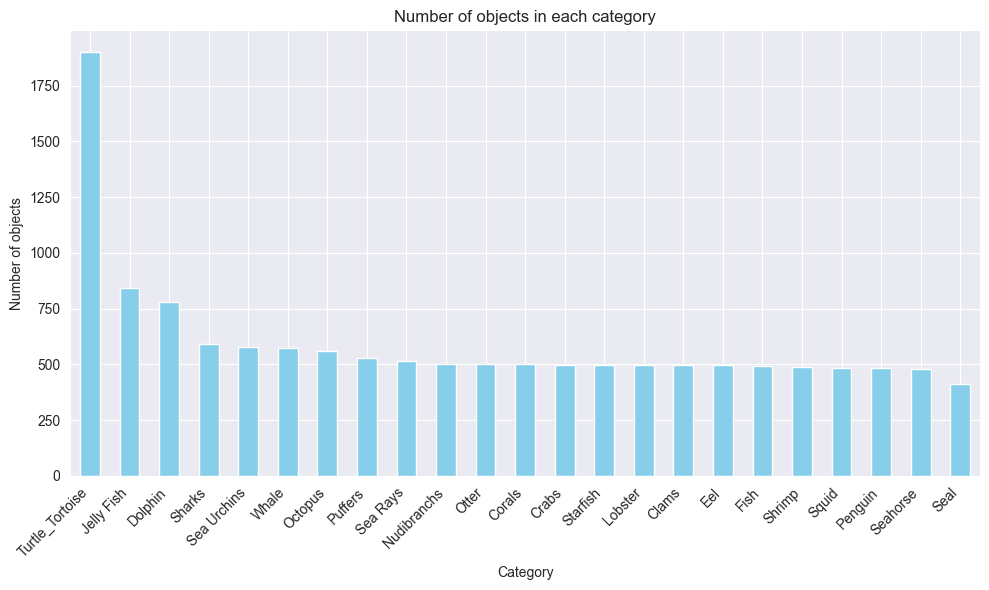

In [9]:
plot_category_counts(df_animals)

In [10]:
df_animals_balance = balance_dataframe_by_record_reduction(df_animals)

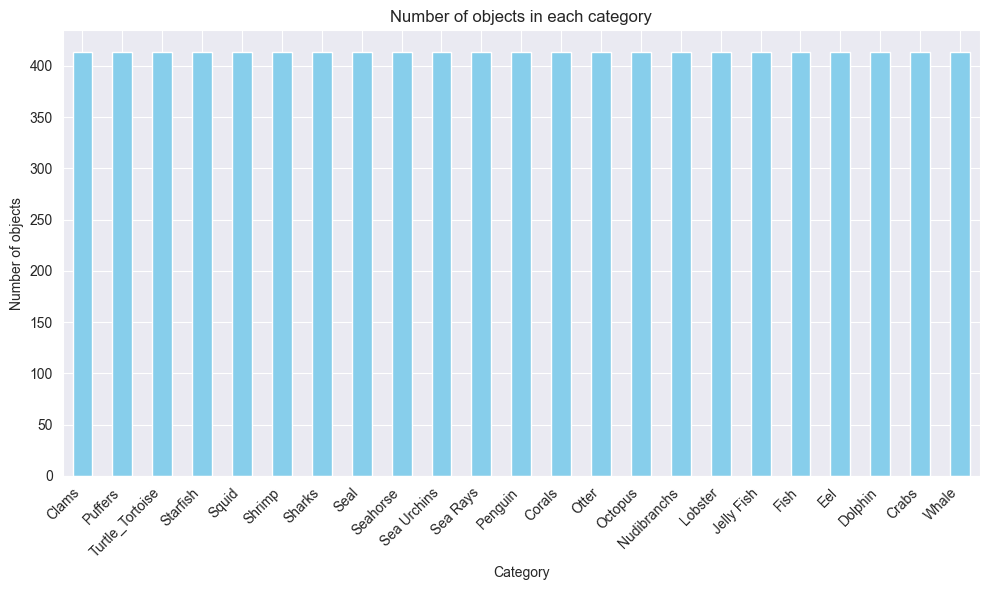

In [11]:
plot_category_counts(df_animals_balance)

# Build Model

In [15]:
# Splitting the data into training and testing sets
train_df, test_df = train_test_split(df_animals_balance, test_size=0.2, shuffle=True, random_state=42)

# Encoding category labels
label_encoder = LabelEncoder()
train_df['Category_encoded'] = label_encoder.fit_transform(train_df['Category'])
test_df['Category_encoded'] = label_encoder.transform(test_df['Category'])

# Definition of image generator for training set with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Definition of image generator for testing set (without augmentation)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Loading and preparing training data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Image_Path",
    y_col="Category",
    target_size=(224, 224),  # Input size for MobileNetV2 model
    batch_size=32,
    class_mode="categorical",
    shuffle=True
)

# Loading and preparing testing data
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Image_Path",
    y_col="Category",
    target_size=(224, 224),  # Input size for MobileNetV2 model
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

# Building a transfer learning model with MobileNetV2
base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Building the classification head
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(len(label_encoder.classes_), activation="softmax")(head_model)

# Connecting the head with the base model
model = Model(inputs=base_model.input, outputs=head_model)

# Freezing the weights of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compiling the model
opt = Adam(lr=1e-4)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# Training the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=test_generator,
    validation_steps=test_generator.samples // 32,
    epochs=20
)

# Evaluating the model on the testing set
predictions = model.predict(test_generator, steps=test_generator.samples // 32 + 1)
predicted_classes = label_encoder.inverse_transform(predictions.argmax(axis=-1))


Found 7617 validated image filenames belonging to 23 classes.
Found 1905 validated image filenames belonging to 23 classes.


Epoch 1/20
238/238 [==============================] - 54s 222ms/step - loss: 2.0108 - accuracy: 0.4183 - val_loss: 1.0982 - val_accuracy: 0.6859
Epoch 2/20
238/238 [==============================] - 52s 217ms/step - loss: 1.3767 - accuracy: 0.5860 - val_loss: 0.9341 - val_accuracy: 0.7256
Epoch 3/20
238/238 [==============================] - 52s 217ms/step - loss: 1.2612 - accuracy: 0.6163 - val_loss: 0.9059 - val_accuracy: 0.7315
Epoch 4/20
238/238 [==============================] - 52s 217ms/step - loss: 1.1729 - accuracy: 0.6389 - val_loss: 0.8485 - val_accuracy: 0.7447
Epoch 5/20
238/238 [==============================] - 52s 217ms/step - loss: 1.1429 - accuracy: 0.6467 - val_loss: 0.8502 - val_accuracy: 0.7479
Epoch 6/20
238/238 [==============================] - 52s 219ms/step - loss: 1.1072 - accuracy: 0.6646 - val_loss: 0.8566 - val_accuracy: 0.7383
Epoch 7/20
238/238 [==============================] - 52s 218ms/step - loss: 1.0420 - accuracy: 0.6816 - val_loss: 0.8369 - val_ac

### Model Evaluation Metrics

The test dataset is utilized to evaluate the performance of the model. Several metrics, including accuracy, precision, recall, and F1 score, are commonly employed to assess model performance.

#### Accuracy
Accuracy measures the fraction of correct predictions made by the model. It is calculated as:

<div style="text-align:center">
<img src="https://latex.codecogs.com/png.latex?\dpi{150}&space;\bg_white&space;\text{Accuracy}&space;=&space;\frac{\text{Number&space;of&space;Correct&space;Predictions}}{\text{Total&space;Number&space;of&space;Predictions}}" alt="Accuracy">
</div>

#### Precision (P)
Precision indicates the fraction of true positives (TP, correct predictions) from the total relevant results, considering both TP and false positives (FP). In multi-class classification problems, precision is averaged among all classes. The formula for precision is:

<div style="text-align:center">
<img src="https://latex.codecogs.com/png.latex?\dpi{150}&space;\bg_white&space;P&space;=&space;\frac{TP}{TP&space;&plus;&space;FP}" alt="Precision">
</div>

#### Recall (R)
Recall represents the fraction of TP from the total TP and false negatives (FN). In multi-class classification problems, recall is averaged across all classes. The formula for recall is:

<div style="text-align:center">
<img src="https://latex.codecogs.com/png.latex?\dpi{150}&space;\bg_white&space;R&space;=&space;\frac{TP}{TP&space;&plus;&space;FN}" alt="Recall">
</div>

#### F1 Score (F1)
The F1 score is the harmonic mean of precision and recall. Like precision and recall, it is averaged among all classes in multi-class classification problems. The formula for the F1 score is:

<div style="text-align:center">
<img src="https://latex.codecogs.com/png.latex?\dpi{150}&space;\bg_white&space;F1&space;=&space;2&space;\times&space;\frac{TP&space;\times&space;FP}{TP&space;&plus;&space;FP}" alt="F1 Score">
</div>

These metrics provide valuable insights into the model's performance across different aspects such as correctness, relevance, and balance between precision and recall.

In [16]:
report = classification_report(test_df['Category'], predicted_classes)
print("Classification Report:\n", report)

Classification Report:
                  precision    recall  f1-score   support

          Clams       0.59      0.67      0.63        90
         Corals       0.60      0.73      0.66        85
          Crabs       0.96      0.90      0.93        82
        Dolphin       0.82      0.77      0.79        92
            Eel       0.50      0.72      0.59        72
           Fish       0.79      0.48      0.60        87
     Jelly Fish       0.92      0.93      0.93        87
        Lobster       0.82      0.72      0.77        90
    Nudibranchs       0.58      0.73      0.65        62
        Octopus       0.54      0.53      0.54        92
          Otter       0.98      1.00      0.99        89
        Penguin       0.89      0.86      0.88        95
        Puffers       0.85      0.64      0.73        87
       Sea Rays       0.48      0.75      0.59        71
    Sea Urchins       0.95      1.00      0.98        83
       Seahorse       0.80      0.55      0.65        73
      